In [1]:
from qwak.qwak import QWAK
from utils.plotTools import searchProbStepsPlotting,searchProbStepsPlotting2

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
import math

import scipy.sparse as sps

import numba
from numba import jit
import random

from gurobipy import *
import gurobipy as grb

from platform import python_version
print('Python:', python_version())
print('Numba: ', numba.__version__)


Python: 3.10.9
Numba:  0.56.4


In [11]:
def decimal_to_ket(n, num_qubits):
    """
    Converts a decimal number to a numpy matrix representing its quantum computing ket notation 
    in the computational basis.
    
    Parameters:
    n (int): Decimal number to be converted.
    num_qubits (int): Number of qubits in the quantum circuit. 
    
    Returns:
    matrix (numpy.ndarray): Matrix representation of the ket notation of the decimal number 
    in the computational basis.
    """
    ket_notation = bin(n)[2:].zfill(num_qubits)
    matrix = np.zeros((2 ** num_qubits, 1))
    matrix[int(ket_notation, 2)][0] = 1
    return matrix

def randomEnergyHamiltonian(nQubits,energies):
    N = 2**nQubits
    hamiltonian = np.zeros((N,N))
    for j in range(0,N):
        state = decimal_to_ket(j,nQubits)
        hamiltonian += energies[j] * np.outer(state,state)
    return np.matrix(hamiltonian)

def is_unitary(matrix: np.ndarray) -> bool:
    return np.allclose(np.eye(len(matrix)), matrix.H*matrix)

def z_gate(nQubits,targetQubit):
    zGate = np.array([[1,0],[0,-1]])
    idGate = np.array([[1,0],[0,1]])
    largeIdGate = idGate
    largeIdGate2 = idGate
    for i in range(0,targetQubit-1):
        largeIdGate = np.kron(idGate,largeIdGate)

    for i in range(targetQubit+1,nQubits-1):
        largeIdGate2 = np.kron(idGate,largeIdGate2)
    largeZGate = np.kron(np.kron(largeIdGate, zGate),largeIdGate2)
    return largeZGate

def Zj_operator(n, j):
    I = np.eye(2)
    Z = np.array([[1, 0], [0, -1]])
    operators = [I]*n
    operators[j] = Z
    operator = np.kron(operators[0], operators[1])
    for k in range(2, n):
        operator = np.kron(operator, operators[k])
    return operator.reshape(2**n, 2**n)

# REM

In [5]:
# energyFj = np.load('Datasets/SpinGlass/rem_instances/rem_instances/aabqpiididwalchfdxeehremvyeldt.nrg.npy') #5 qubits
energyFj = np.load('Datasets/SpinGlass/rem_instances/rem_instances/aaawtshnbzkjyxorphyjanhkhjedjb.nrg.npy') #9 qubits
nQubits = int(np.log2(len(energyFj)))
remHamiltonian = randomEnergyHamiltonian(nQubits,energyFj)
print(is_unitary(remHamiltonian))

False


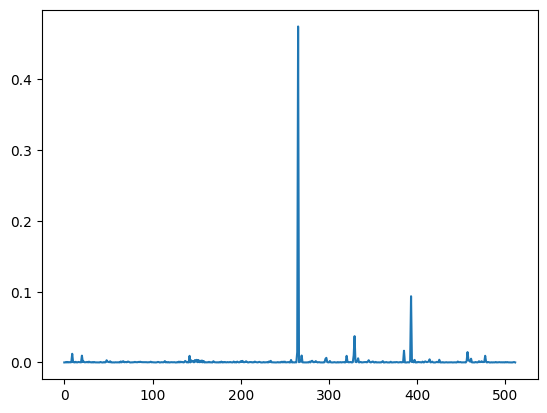

In [16]:
n = 2**nQubits
t = (np.pi/2) * np.sqrt(n) 
timeList = [ x for x in np.linspace(0,80,50)]

# gamma = 0.38863810323671366
gamma = 0.41708811804605234
initCond = list(range(0,n))
graph = nx.hypercube_graph(nQubits)

qw = QWAK(graph=graph,gamma=gamma,laplacian=False)

walkHamiltonian = qw.getHamiltonian()
# print(-walkHamiltonian)
# print(is_unitary(np.matrix(walkHamiltonian)))
# print(np.eye(len(walkHamiltonian)))
# print(walkHamiltonian.dot(walkHamiltonian.T.conj()))
remWalkHamiltonian = walkHamiltonian + remHamiltonian
qw.setHamiltonian(remWalkHamiltonian)
# print(is_unitary(np.array([[1,0],[0,-1]])))

# qw.runMultipleWalks(timeList=timeList,initStateList=initCond)
qw.runWalk(time=t,initStateList=initCond)
plt.plot(qw.getProbVec())

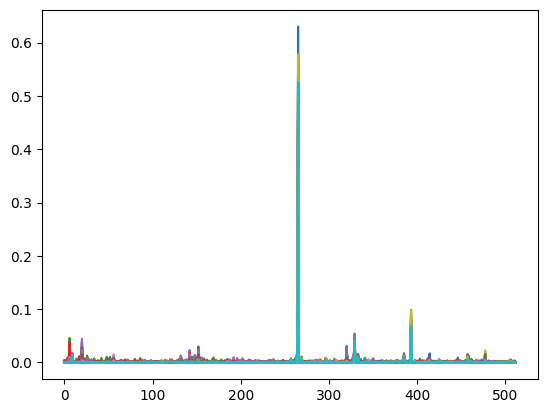

In [28]:
for prob in qw.getProbVecList():
    plt.plot(prob)

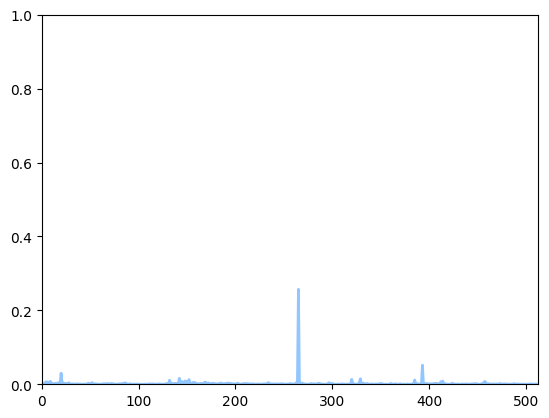

In [37]:
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    n = 2**nQubits
    gamma = 0.41708811804605234
    initCond = list(range(0,n))
    graph = nx.hypercube_graph(nQubits)
    qw = QWAK(graph=graph,gamma=gamma,laplacian=False)
    walkHamiltonian = qw.getHamiltonian()
    remWalkHamiltonian = walkHamiltonian + remHamiltonian
    qw.setHamiltonian(remWalkHamiltonian)
    qw.runWalk(time=i,initStateList=initCond)
    x = np.arange(0,n)
    y = qw.getProbVec()
    line.set_data(x,y)
    return line,


fig = plt.figure()
ax = plt.axes(xlim=(0, 2**nQubits), ylim=(0, 1))
line, = ax.plot([], [], lw=2)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=400, blit=True)
anim.save('ContQuantumWalk.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# SK

In [17]:
import numpy as np

def quantum_SK_model(n,J, h):
    """
    Constructs the quantum Hamiltonian for the Sherrington-Kirkpatrick model with single-body field terms.
    
    Args:
        J (float): the coupling strength between qubits
        h (float): the strength of the external field
        n (int): the number of qubits
        
    Returns:
        H (ndarray): the Hamiltonian as a 2D numpy array
    """
    
    # construct pairwise interaction term
    pairwise = 0
    for i in range(n):
        for j in range(i+1, n):
            pairwise += J[i,j] * Zj_operator(n,i) * Zj_operator(n,j)
    
    # construct single-body field term
    field = 0
    for i in range(n):
        field += h[i] * Zj_operator(n,i)
    
    # construct full Hamiltonian
    H = (-1/2)*pairwise - field
    
    return H


In [18]:
energyJjk = np.load('Datasets/SpinGlass/sk_instances/aaagibbewlveughpoboyciorpvqqif.Jmat.npy') #9 qubits
energyHj = np.load('Datasets/SpinGlass/sk_instances/aaagibbewlveughpoboyciorpvqqif.hvec.npy') #9 qubits
print(energyJjk)
print(energyHj)
nQubits = int(np.log2(len(energyJjk)))
print(nQubits)
skHamiltonian = quantum_SK_model(nQubits,energyJjk,energyHj)

[[ 0.          0.07419613 -2.29295572 -0.31681827  1.62807185  0.45335527
   0.59054202 -0.01257174  0.18915022]
 [-0.30330686  0.          0.36690583 -0.05893979  0.23007926 -0.76877928
  -0.59957137 -0.63067881 -1.65091991]
 [ 1.7557956  -1.12222053  0.         -1.64109883  0.64715803 -0.92987957
   1.06662424  0.3093922  -1.65186693]
 [-0.81670933  0.72881206  0.62332892  0.         -1.36359721 -0.55099128
   1.07625356  0.19714299 -0.14434218]
 [ 0.66023908 -0.73533424  1.09337823  2.07008288  0.         -0.71968701
   0.35890107 -1.43011844  0.49972302]
 [ 1.58485761  0.8885108   1.57034504 -0.12667164  0.0565132   0.
   0.15618183 -1.62252024  0.40679374]
 [-0.2717915  -0.52992152  1.76311653  0.45522769  2.0785776   1.17198877
   0.          1.58266973 -2.016024  ]
 [-0.23396422 -0.42472166  0.1460579   1.24600188 -0.84070514 -0.50579291
   1.01575117  0.         -0.85336586]
 [ 0.70475659  2.63944643 -1.44317633 -0.10186023  0.40635385  1.43084418
   0.7021695  -0.18676969  0. 

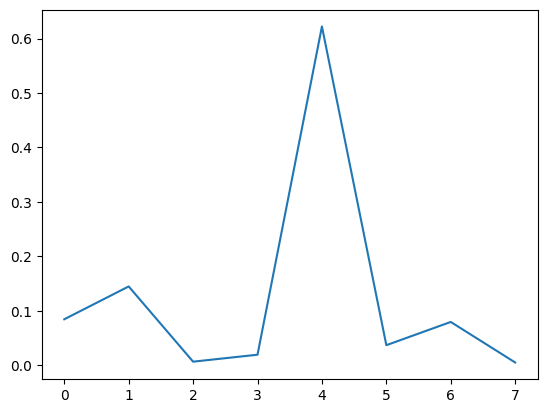

In [19]:
n = 2**nQubits
t = (np.pi/2) * np.sqrt(n) 
timeList = [ x for x in np.linspace(0,80,50)]

# gamma = 0.38863810323671366
gamma = 1.4100649088572166
initCond = list(range(0,n))
graph = nx.hypercube_graph(nQubits)

qw = QWAK(graph=graph,gamma=gamma,laplacian=False)

walkHamiltonian = qw.getHamiltonian()
# print(-walkHamiltonian)
# print(is_unitary(np.matrix(walkHamiltonian)))
# print(np.eye(len(walkHamiltonian)))
# print(walkHamiltonian.dot(walkHamiltonian.T.conj()))
skWalkHamiltonian = walkHamiltonian + skHamiltonian
qw.setHamiltonian(skWalkHamiltonian)
# print(is_unitary(np.array([[1,0],[0,-1]])))

# qw.runMultipleWalks(timeList=timeList,initStateList=initCond)
qw.runWalk(time=t,initStateList=initCond)
plt.plot(qw.getProbVec())